In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
!pip install hmmlearn

In [ ]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from hmmlearn.hmm import GaussianHMM

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

# Function

In [ ]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)

    return new_dataframe

In [ ]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [ ]:
def possibleoutcomes(data):
  data_augmented = augment_features(data)
  fracocp = data_augmented['delOpenClose']
  frachp = data_augmented['delHighOpen']
  fraclp = data_augmented['delLowOpen']

  sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
  sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
  sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

  possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

  return possible_outcomes

In [ ]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
def train_test_valid(data):
  test_size  = 0.2
  valid_size = 0.1

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  train_data, test_data, valid_data = data[:valid_split_idx], data[valid_split_idx+1:test_split_idx], data[test_split_idx+1:]

  return train_data, test_data, valid_data

# HoaPhat_HPG

## Data

In [ ]:
df_amz = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/HoaPhat_HPG_y_m_d.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,10260.39,10443.02,10227.19,10227.19,10227.19,12637219.0
1,2019-01-03,10210.59,10260.39,9795.52,9795.52,9795.52,21178963.0
2,2019-01-04,9762.32,9961.55,9529.88,9861.93,9861.93,20085098.0
3,2019-01-07,10061.16,10077.77,9679.30,9745.71,9745.71,7495579.0
4,2019-01-08,9762.32,9795.52,9529.88,9579.69,9579.69,12767952.0
...,...,...,...,...,...,...,...
1537,2025-03-06,27600.00,27950.00,27600.00,27950.00,27950.00,37159600.0
1538,2025-03-07,28000.00,28100.00,27750.00,28050.00,28050.00,33131210.0
1539,2025-03-10,28100.00,28200.00,27950.00,27950.00,27950.00,23863520.0
1540,2025-03-11,27600.00,28150.00,27600.00,28150.00,28150.00,26088500.0


## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_amz.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-14-e30130b711a2>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_amz.iloc[0][0])
<ipython-input-14-e30130b711a2>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_amz.iloc[-1][0])
<ipython-input-14-e30130b711a2>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])


### Visualize the per day closing price of the stock

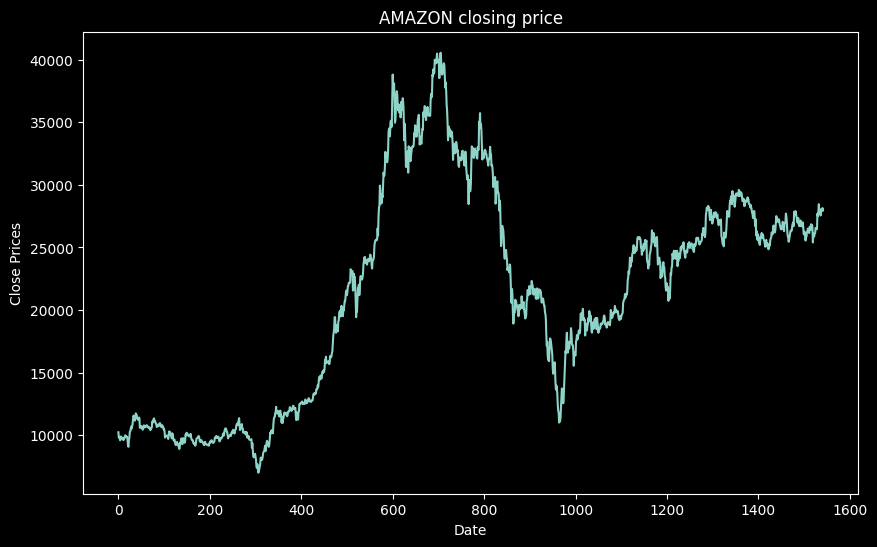

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

In [ ]:
train_data, test_data, valid_data = train_test_valid(df_amz)

In [ ]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

feature_val_data = augment_features(valid_data)
features_val = extract_features(feature_val_data)

feature_test_data = augment_features(test_data)
features_test = extract_features(feature_test_data)

## Build & Train model

In [ ]:
model = GaussianHMM()

### Choose n_component

In [ ]:
n_components_values = [4, 6, 8, 10, 12, 14]
num_latent_days = 50
num_days_to_predict = 100

In [ ]:
possible_outcomes_test = possibleoutcomes(test_data)

In [ ]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes_test:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.vstack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


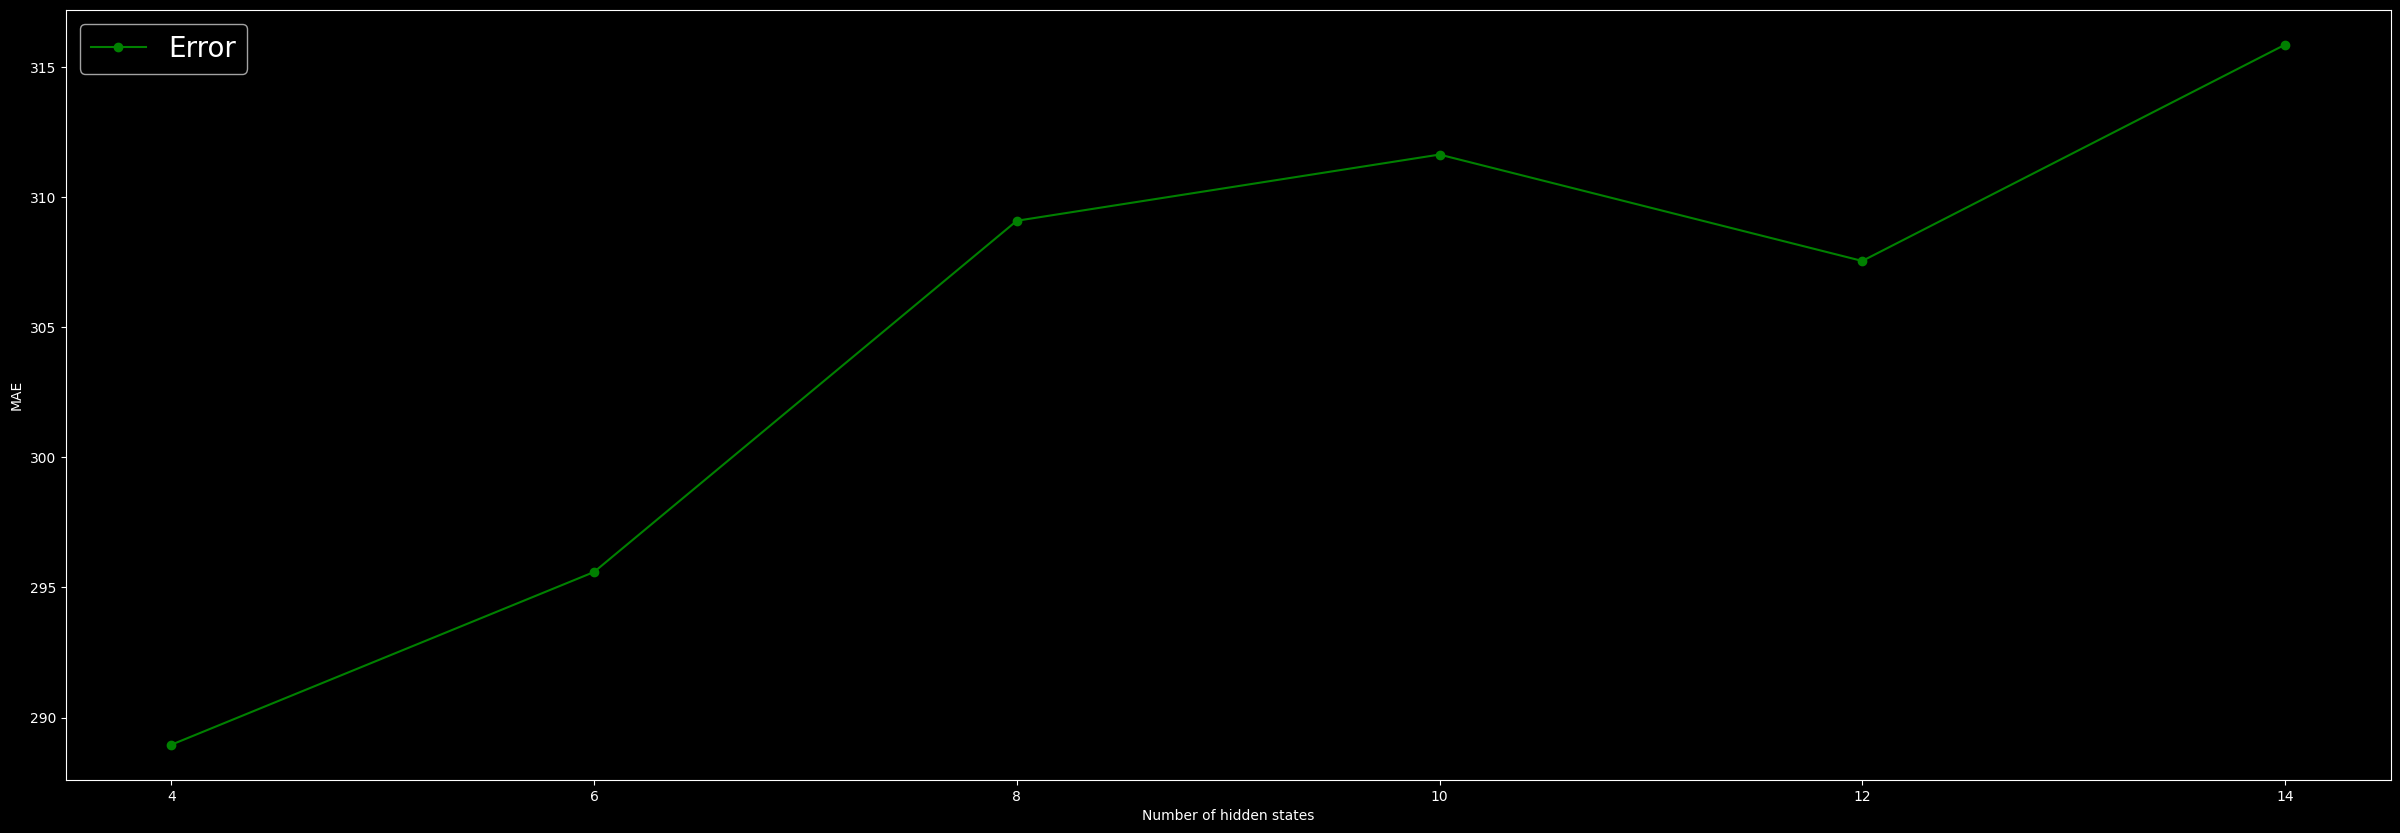

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

### Train

In [ ]:
model = GaussianHMM(n_components=12).fit(features_train)

## Eval

In [ ]:
predict_test = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_test:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.vstack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
    predict_test.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]


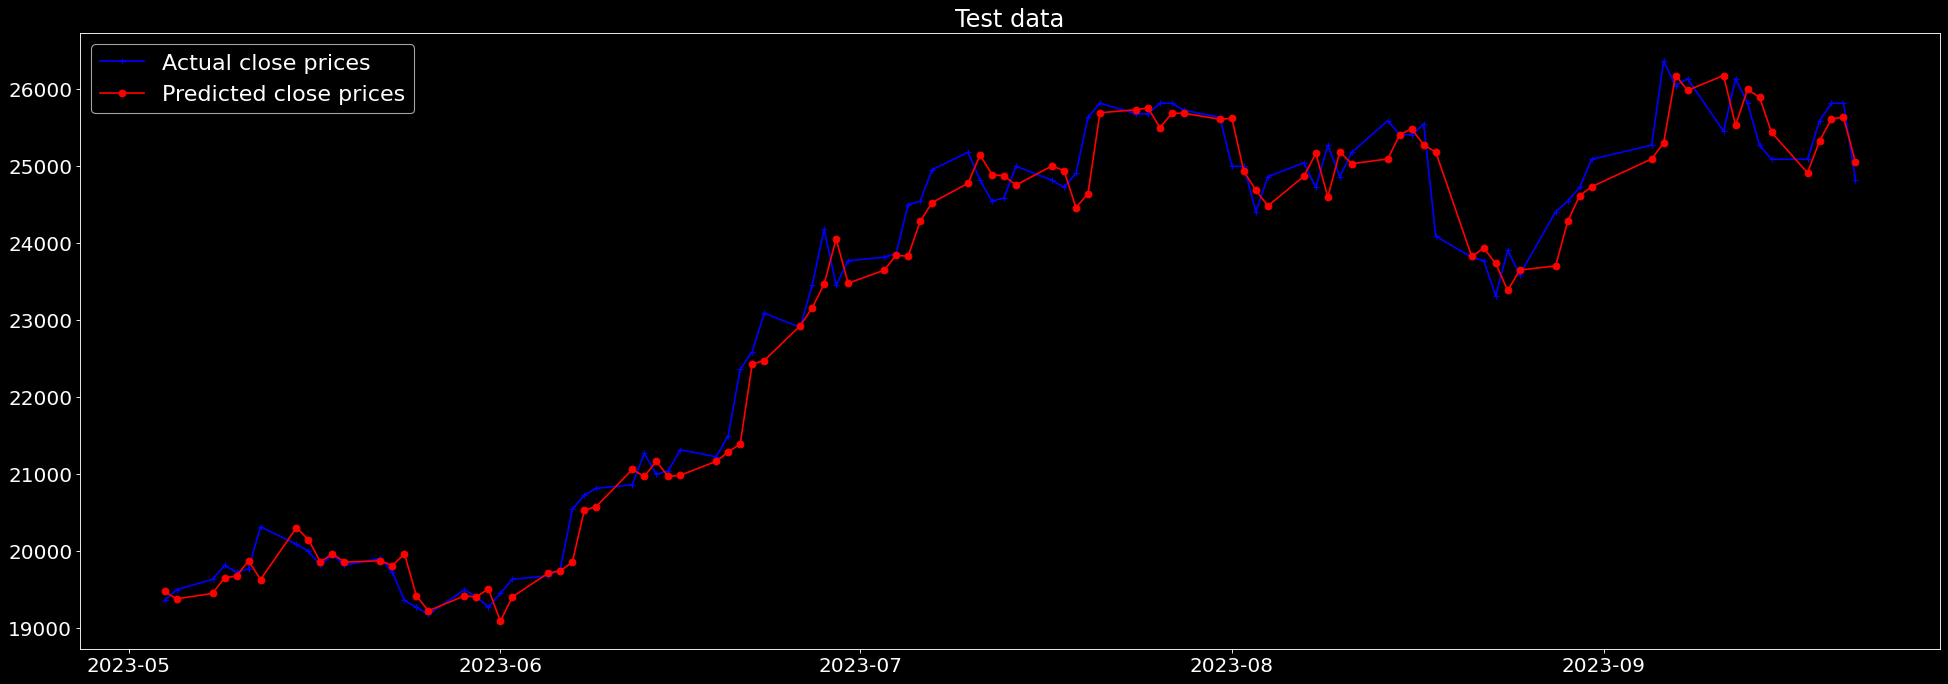

In [ ]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_test, 'ro-', label="Predicted close prices")
plt.title('Test data')
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
possible_outcomes_val = possibleoutcomes(valid_data)

predict_val = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(valid_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_val:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.vstack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_val[np.argmax(outcome_scores)]
    predict_val.append(valid_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


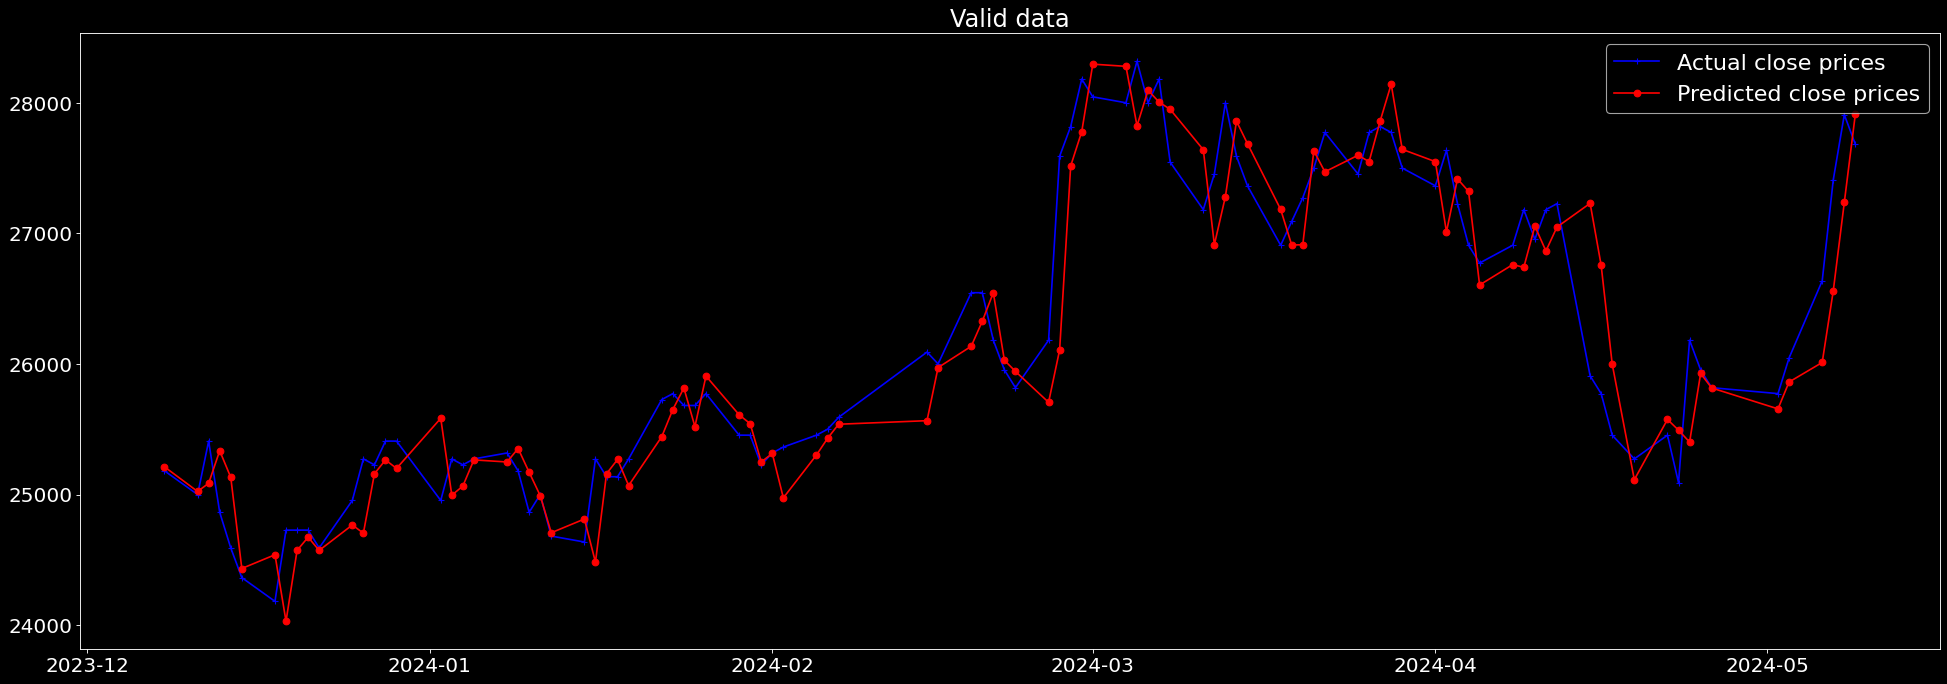

In [ ]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(valid_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, valid_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_val, 'ro-', label="Predicted close prices")
plt.title('Valid data')
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
eval(test_data.iloc[0:num_days_to_predict]['Close'],predict_test,valid_data.iloc[0:num_days_to_predict]['Close'],predict_val)

** Testing **
MAE:  283.5261549729802
MAPE:  1.204078492206394
RMSE:  376.79649447842854

** Validate **
MAE:  290.4772570945483
MAPE:  1.1013471489483773
RMSE:  394.9680869383061


# NamKim_NKG

## Data

In [ ]:
df_tsla = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/NamKim_NKG_y_m_d.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,4565.97,4577.55,4403.94,4403.94,4403.94,65576.0
1,2019-01-03,4403.94,4496.53,4195.60,4195.60,4195.60,559110.0
2,2019-01-04,4195.60,4195.60,3946.76,4079.86,4079.86,116707.0
3,2019-01-07,4079.86,4224.54,4079.86,4079.86,4079.86,132570.0
4,2019-01-08,4079.86,4155.09,4056.71,4079.86,4079.86,137979.0
...,...,...,...,...,...,...,...
1540,2025-03-06,15550.00,16100.00,15500.00,16100.00,16100.00,14202800.0
1541,2025-03-07,16050.00,16300.00,15900.00,16100.00,16100.00,10169700.0
1542,2025-03-10,16150.00,16200.00,15700.00,15800.00,15800.00,9795200.0
1543,2025-03-11,15500.00,16100.00,15400.00,16100.00,16100.00,14542500.0


## Preprocessing

### Check null and na value

In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_tsla.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-38-72eea4c1fa3f>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_tsla.iloc[0][0])
<ipython-input-38-72eea4c1fa3f>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_tsla.iloc[-1][0])
<ipython-input-38-72eea4c1fa3f>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])


### Visualize the per day closing price of the stock

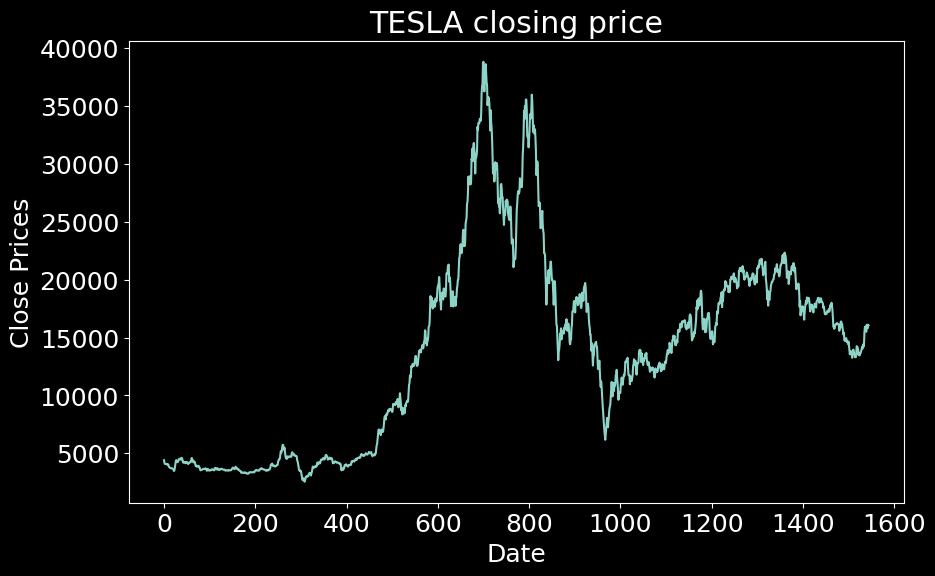

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

In [ ]:
train_data, test_data, valid_data = train_test_valid(df_tsla)

In [ ]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

feature_val_data = augment_features(valid_data)
features_val = extract_features(feature_val_data)

feature_test_data = augment_features(test_data)
features_test = extract_features(feature_test_data)

## Build & Train model

In [ ]:
model = GaussianHMM()

### Choose n_component

In [ ]:
n_components_values = [4, 6, 8, 10, 12, 14]
num_latent_days = 50
num_days_to_predict = 100

In [ ]:
possible_outcomes_test = possibleoutcomes(test_data)

In [ ]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes_test:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.vstack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 100/100 [03:35<00:00,  2.16s/it]


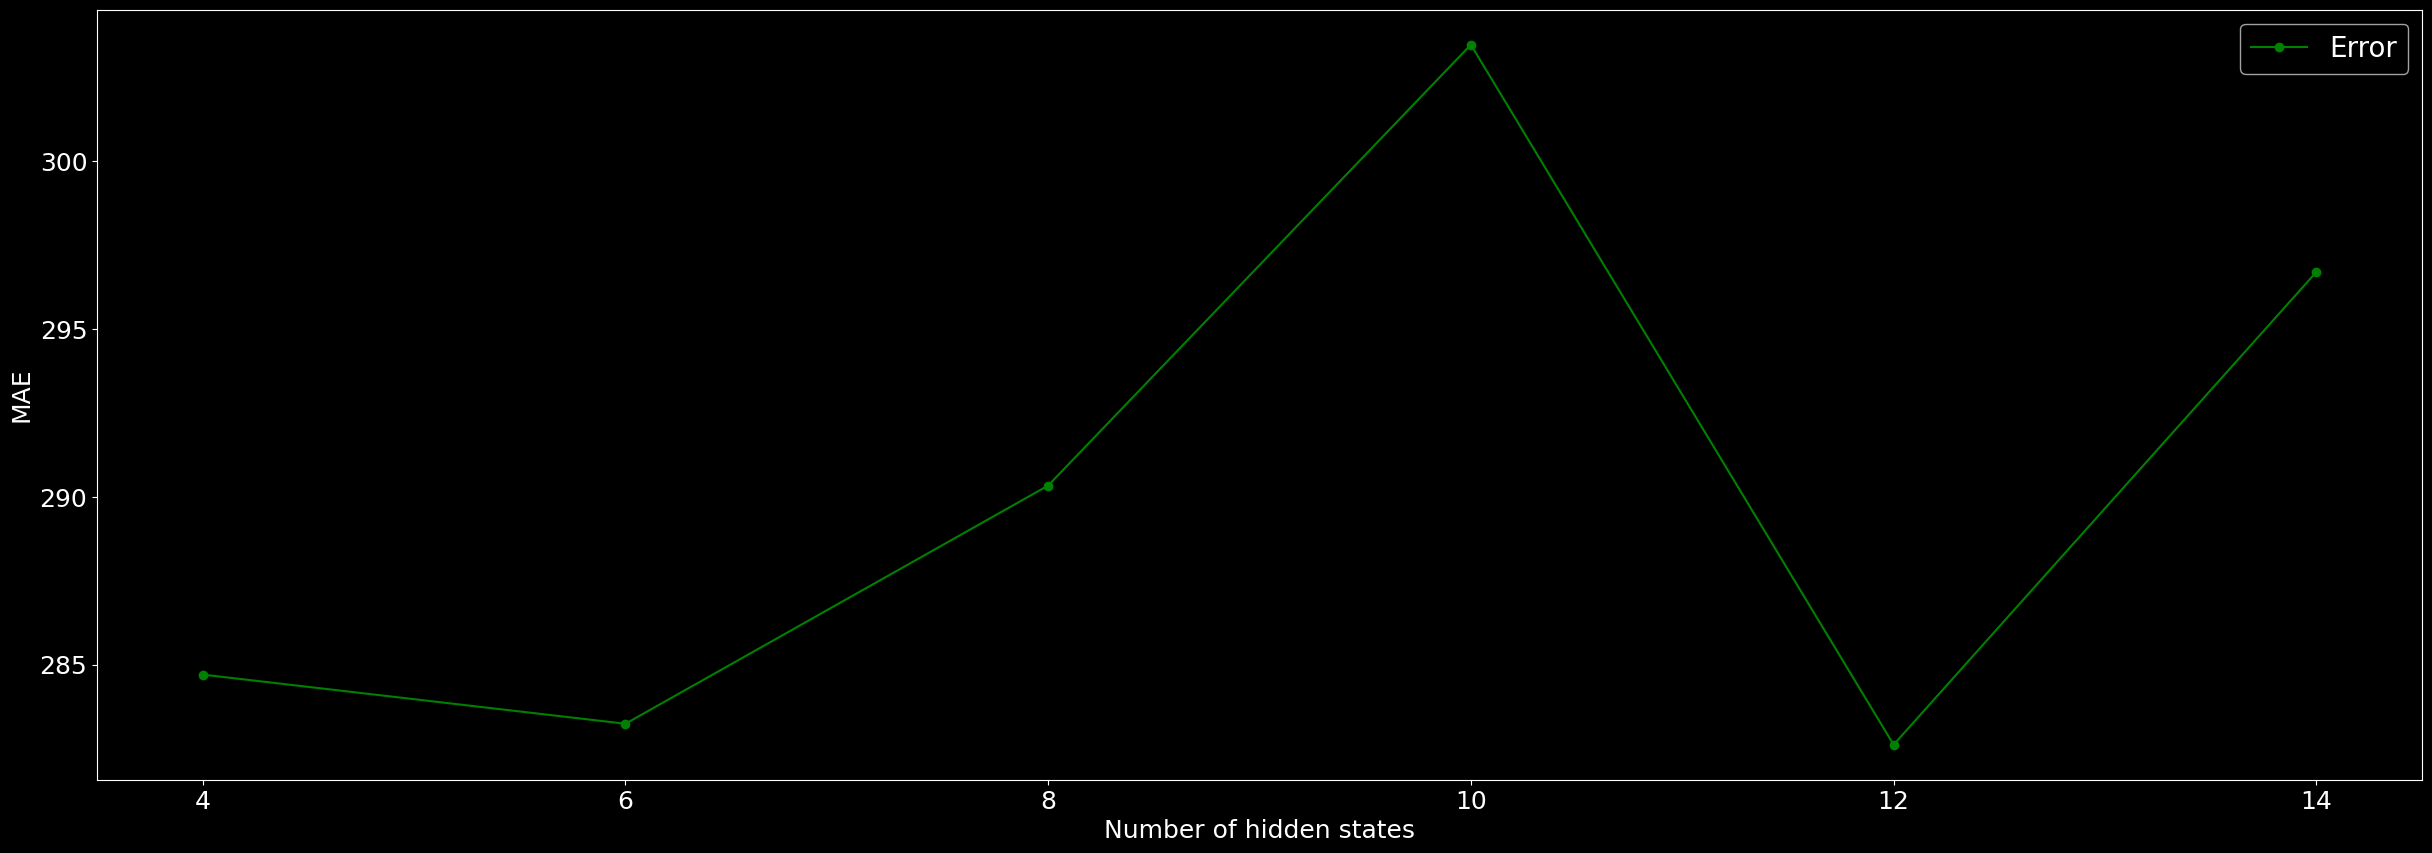

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

### Train

In [ ]:
model = GaussianHMM(n_components=8).fit(features_train)

## Eval

In [ ]:
predict_test = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_test:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.vstack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
    predict_test.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


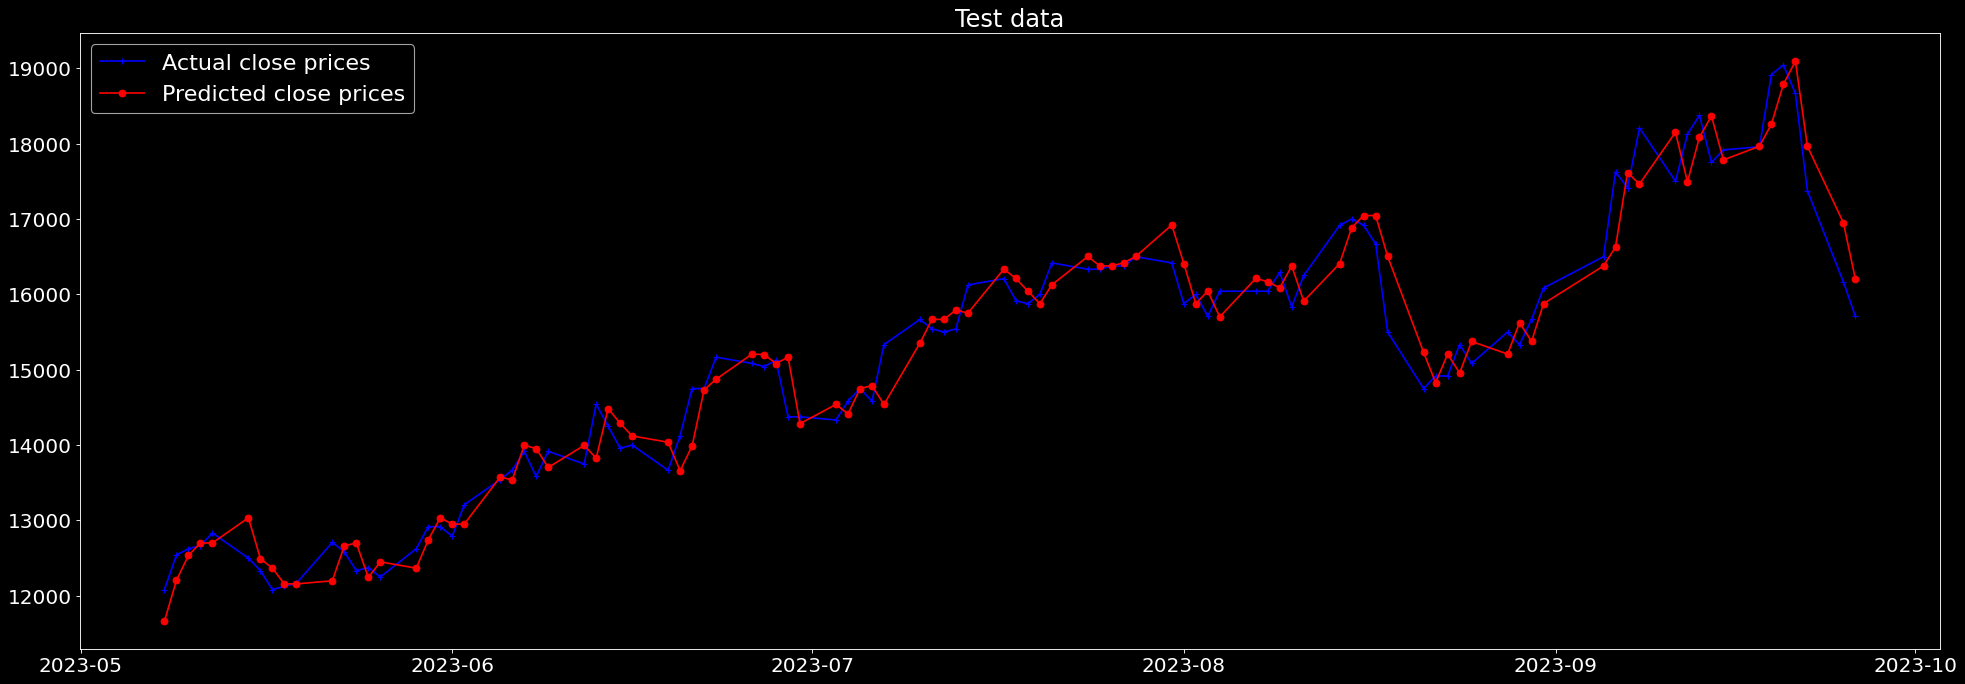

In [ ]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_test, 'ro-', label="Predicted close prices")
plt.title('Test data')
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
possible_outcomes_val = possibleoutcomes(valid_data)

predict_val = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(valid_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_val:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.vstack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_val[np.argmax(outcome_scores)]
    predict_val.append(valid_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


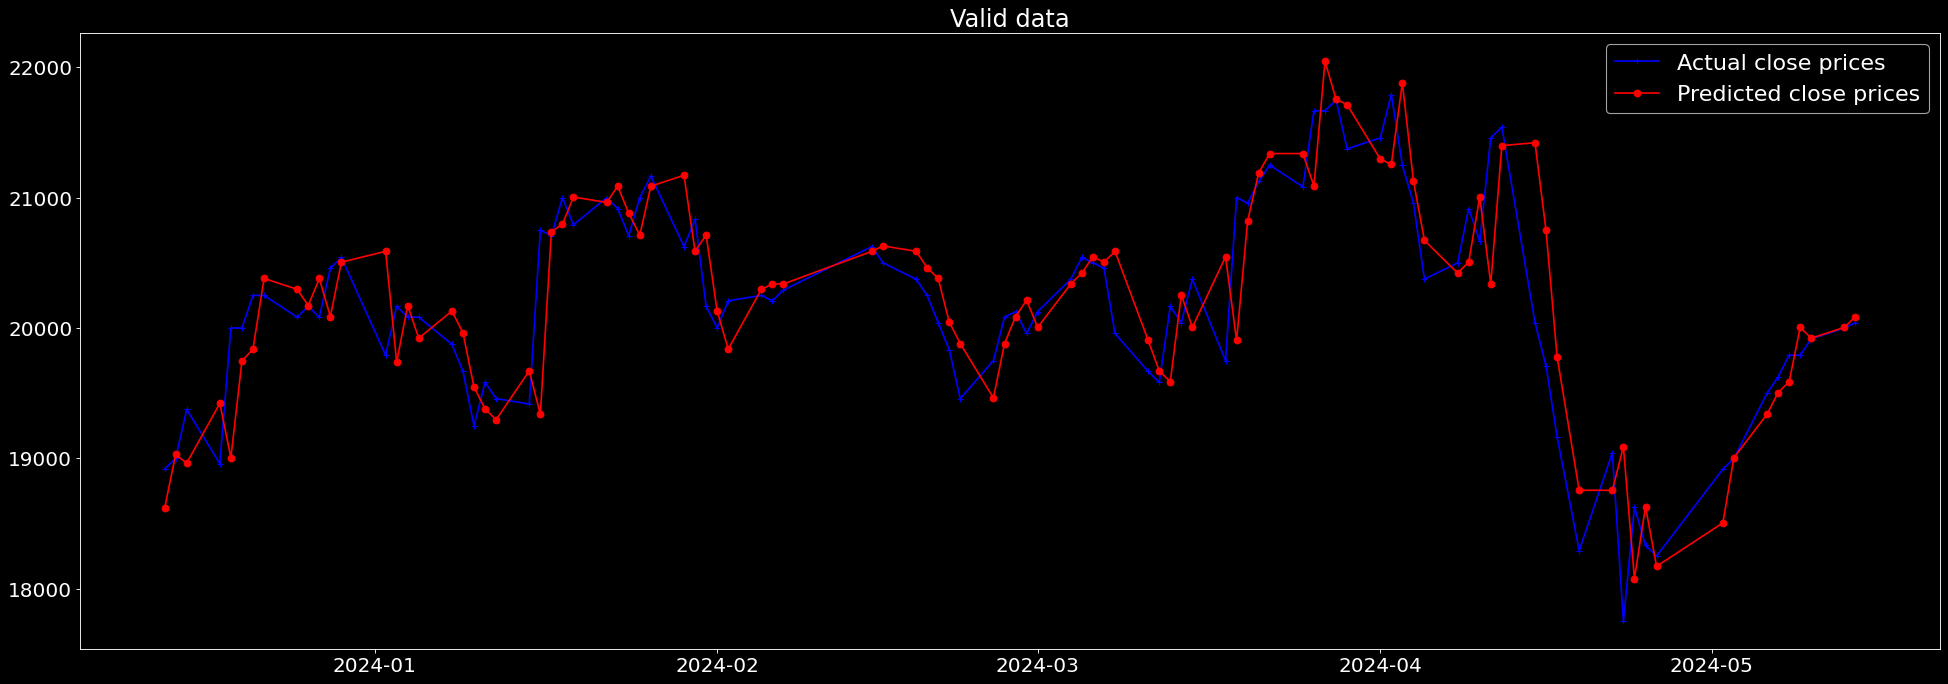

In [ ]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(valid_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, valid_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_val, 'ro-', label="Predicted close prices")
plt.title('Valid data')
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
eval(test_data.iloc[0:num_days_to_predict]['Close'],predict_test,valid_data.iloc[0:num_days_to_predict]['Close'],predict_val)

** Testing **
MAE:  293.27399476319295
MAPE:  1.9187583999767408
RMSE:  370.7118376096092

** Validate **
MAE:  312.11019942869694
MAPE:  1.5564723313825426
RMSE:  435.78650619647755
